## Self-RAG

This notebook implements Self-RAG (Self-Reflective Retrieval-Augmented Generation), which combines:
- Document relevance grading
- Hallucination detection
- Answer completeness checking
- Query rewriting for better retrieval

Flow:
1. Query -> Retrieve -> Grade documents
2. If relevant -> Generate -> Check hallucinations -> Check answer quality
3. If not relevant -> Transform query -> Retrieve again
4. If hallucinations -> Regenerate
5. If doesn't answer query -> Transform query -> Retrieve again

https://arxiv.org/abs/2310.11511

🔗 Join the Discord Community: https://discord.gg/RFjwbkNa


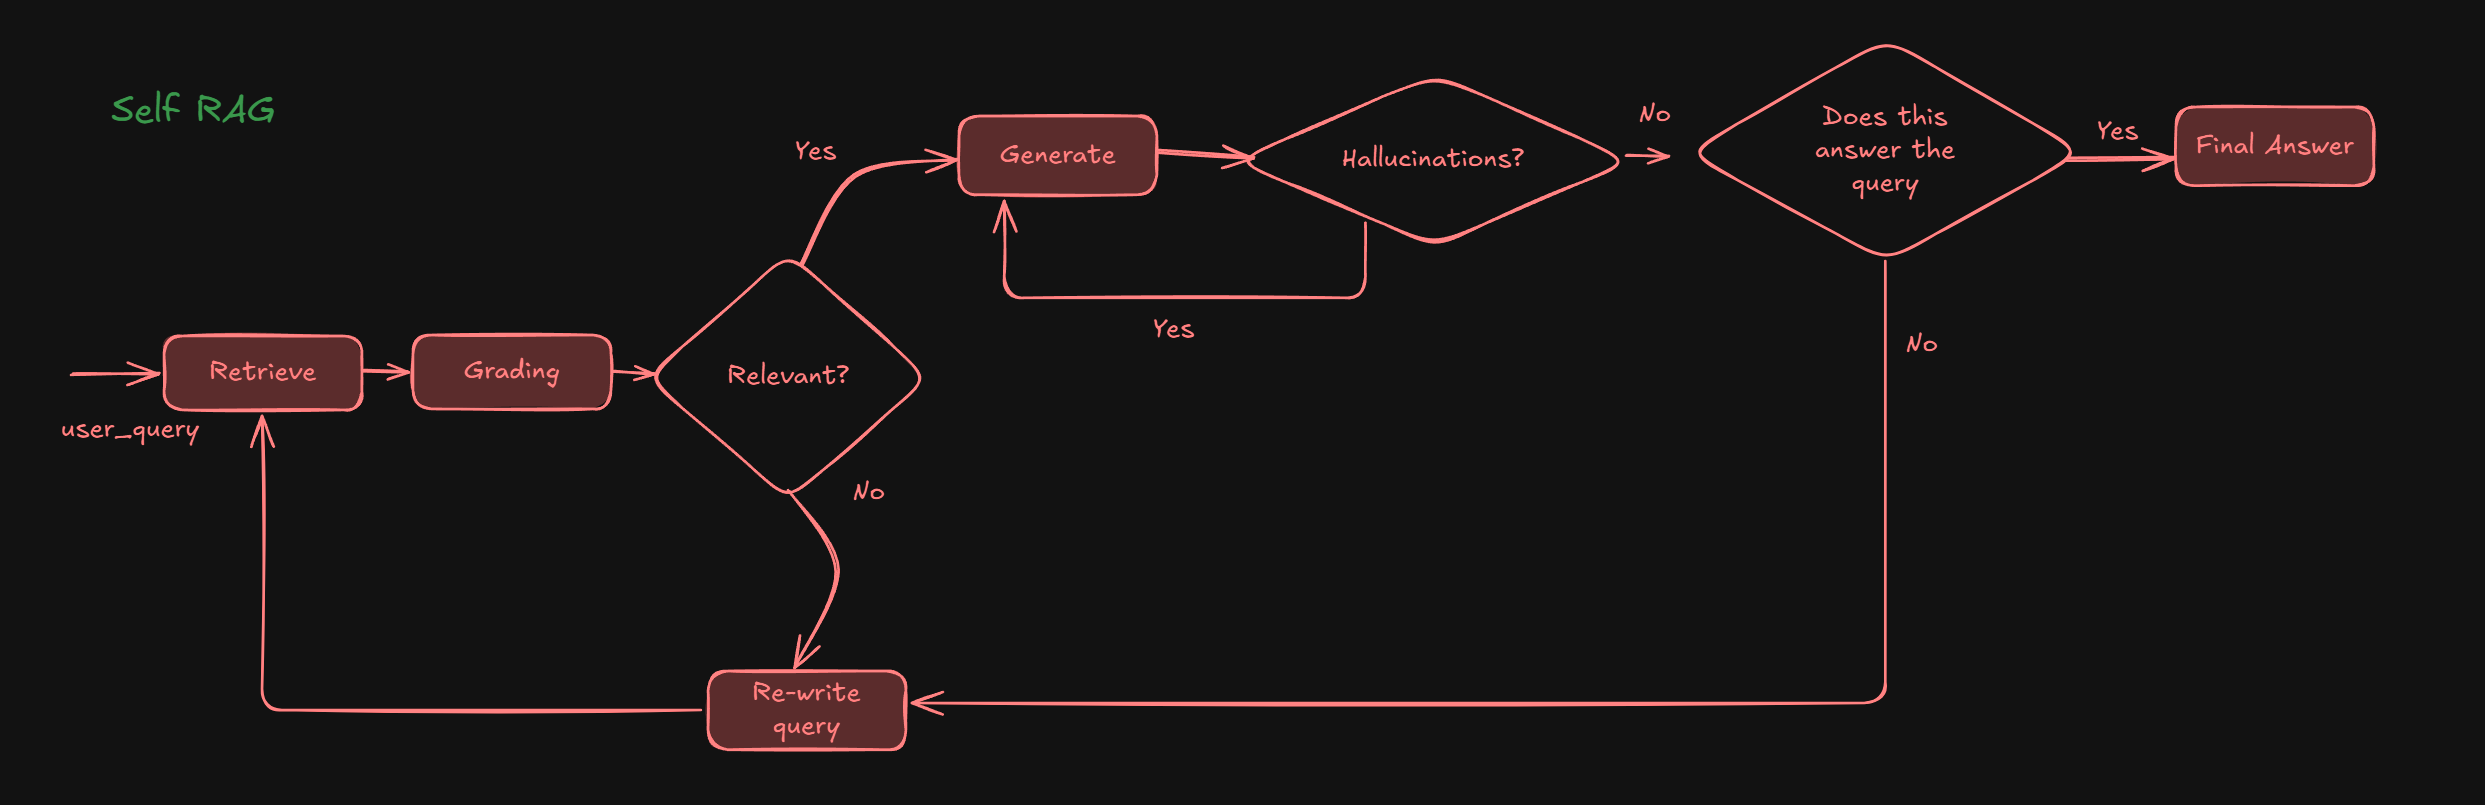

In [1]:
from typing_extensions import TypedDict, Annotated
from typing import List
import os
import operator

from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field

from scripts import my_tools

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# =============================================================================
# Configuration
# =============================================================================

LLM_MODEL = "qwen3"
BASE_URL = "http://localhost:11434"

llm = ChatOllama(model=LLM_MODEL, base_url=BASE_URL, reasoning=True)

In [3]:
result = llm.invoke('hi')
result.pretty_print()

================================== Ai Message ==================================

Hello! 😊 How can I assist you today? Whether you have questions, need help with something, or just want to chat, I'm here for you! What's on your mind?


In [4]:
print(result.additional_kwargs['reasoning_content'])

Okay, the user said "hi /think". Let me start by acknowledging their greeting. Since they included "/think", maybe they want me to take a moment to consider my response. I should respond warmly and offer assistance. I'll keep it friendly and open-ended so they feel comfortable asking anything. Let me make sure the tone is positive and approachable. Alright, time to craft a response that's both welcoming and helpful.



In [5]:
# =============================================================================
# Pydantic Schemas for Structured Outputs
# =============================================================================
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: str = Field(description="Documents are relevant to the query, 'yes' or 'no'")


class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""
    binary_score: str = Field(description="Answer is grounded with the facts for the query, 'yes' or 'no'")


class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses query."""
    binary_score: str = Field(description="Answer addresses the query, 'yes' or 'no'")


class SearchQueries(BaseModel):
    """Search queries for retrieving missing information."""
    search_queries: list[str] = Field(description="1-3 search queries to retrieve the missing information.")


In [ ]:
# =============================================================================
# State
# =============================================================================
class AgentState(TypedDict):
    messages: Annotated[list, operator.add]
    retrieved_docs: str
    rewritten_queries: List[str]

### LangGraph Nodes

In [7]:
# =============================================================================
# LangGraph Nodes
# =============================================================================

# Retrieve documents based on user query
def retrieve_node(state: AgentState):

    print("[RETRIEVE] fetching documents...")

    query = state['messages'][0].content

    rewritten_queries = state.get('rewritten_queries', [])

    # use rewriten queries if present
    queries_to_search = rewritten_queries if rewritten_queries else [query]

    all_results = []
    for idx, search_query in enumerate(queries_to_search, 1):
        print(f"[RETRIEVE] Query {idx}: {search_query}")

        # 3(Reranking) -> 3*10(Retrieval) -> 3*10*20 (MMR)
        result = my_tools.retrieve_docs.invoke({'query': search_query, 'k': 3})

        text = f"## Query {idx}: {search_query}\n\n### Retrieved Documents:\n{result}"
        all_results.append(text)


    combined_result = "\n\n".join(all_results)


    os.makedirs('debug_logs', exist_ok=True)
    with open('debug_logs/self_rag.md', 'w', encoding='utf-8') as f:
        f.write(combined_result)

    return {
        'retrieved_docs': combined_result
    }


In [8]:
# Grade document relevance and filter out irrelevant ones
def grade_documents_node(state: AgentState):

    print("[GRADE] Evaluating document relevance")

    query = state['messages'][0].content
    documents = state.get('retrieved_docs', 'No document available!')

    llm_structured = llm.with_structured_output(GradeDocuments)

    system_prompt = """You are a grader assessing relevance of retrieved documents to a user query.

                It does not need to be a stringent test. The goal is to filter out erroneous retrievals.

                If the document contains keyword(s) or semantic meaning related to the user query, grade it as relevant.

                Give a binary score 'yes' or 'no' to indicate whether the document is relevant to the query."""
    

    system_msg = SystemMessage(system_prompt)

    messages = [system_msg, HumanMessage(f"Retrieved Document: {documents}\n\nUser query: {query}")]

    response = llm_structured.invoke(messages)

    print(f"[GRADE] Relevance:  {response.binary_score}")

    if response.binary_score == 'yes':
        return {'retrieved_docs': documents}
    
    else:
        return {'retrieved_docs': ''}

In [9]:
# Generate answer based on retrieved documents
def generate_node(state:AgentState):
    print("[GENERATE] Creating Answer")

    query = state['messages'][0].content
    documents = state.get('retrieved_docs', '')

    system_prompt = """You are a financial document analyst providing detailed, accurate answers.

                OUTPUT FORMAT:
                Write a comprehensive answer (200-300 words) in MARKDOWN format:
                - Use ## headings for sections
                - Use **bold** for emphasis
                - Use bullet points or numbered lists
                - Include inline citations like [1], [2] where applicable

                GUIDELINES:
                - Base your answer ONLY on the provided documents
                - Be specific with numbers, dates, and metrics
                - If information is missing, acknowledge it
                - Use proper financial terminology

                CITATIONS:
                At the end, list references in this format:
                **References:**
                1. Company: x, Year: y, Quarter: z, Page: n"""
    
    query_prompt = f"Retrieved Document: {documents}\n\nUser query: {query}"

    system_msg = SystemMessage(system_prompt)
    user_msg = HumanMessage(query_prompt)

    messages = [system_msg, user_msg]

    response = llm.invoke(messages)

    os.makedirs('debug_logs', exist_ok=True)
    with open('debug_logs/self_rag_answer.md', 'w', encoding='utf-8') as f:
        f.write(f"Query: {query}")
        f.write(response.content)

    return {
        'messages': [response]
    }

In [10]:
# Transform the query to produce better search queries
def transform_query_node(state: AgentState):

    query = state['messages'][0].content
    rewritten_queries = state.get('rewritten_queries', [])

    llm_structured = llm.with_structured_output(SearchQueries)

    system_prompt = """You are a query re-writer that decomposes complex queries into focused search queries optimized for vectorstore retrieval.

                DECOMPOSITION STRATEGY:
                Break down the original query into 1-3 specific, focused queries where each query targets:
                - A single company (e.g., "Amazon revenue 2023" vs "Google revenue 2023")
                - A specific time period (e.g., "Q1 2024" vs "Q2 2024")
                - A specific metric or aspect (e.g., "revenue" vs "net income")
                - A specific document section (e.g., "risk factors" vs "business overview")

                GUIDELINES:
                - Expand abbreviations (e.g., "rev" -> "revenue", "GOOGL" -> "Google")
                - Add financial context if missing
                - Make each query self-contained and specific
                - Keep queries concise but clear (5-10 words each)
                - Avoid repeating previously tried queries

                EXAMPLES:
                - "Compare Apple and Google revenue in 2024 Q1" → 
                ["Apple total revenue Q1 2024", "Google total revenue Q1 2024"]
                
                - "Amazon's revenue growth from 2022 to 2024" →
                ["Amazon revenue 2022", "Amazon revenue 2023", "Amazon revenue 2024"]
                
                - "What were the main risks for Microsoft in 2023?" →
                ["Microsoft risk factors 2023", "Microsoft business challenges 2023"]"""
                

    query_context = f"Original Query: {query}"
    if rewritten_queries:
        query_context = query_context + f"\n\n These queries have been already generated. do not generate same queries again.\n"
        for idx, query in enumerate(rewritten_queries, 1):
            query_context = query_context + f"Query {idx}: {query}\n\n"

    query_context = query_context + "\n\nGenerate 1-3 focused search queries that decompose the original query. Each query should target a specific aspect."

    system_msg = SystemMessage(system_prompt)
    user_msg = HumanMessage(query_context)

    messages = [system_msg, user_msg]
    response = llm_structured.invoke(messages)

    new_queries = response.search_queries

    print(f"New Search Queries: {new_queries}")

    return {
        "rewritten_queries": new_queries
    }



### Router Logic

In [11]:
# =============================================================================
# Router Logic
# =============================================================================

# Decide whether to generate answer or transform query
def should_generate(state:AgentState):
    print("[ROUTER] Assess graded documents")

    retrieved_docs = state.get('retrieved_docs', '')
    
    if not retrieved_docs or retrieved_docs.strip() == '':
        print(f"[ROUTER] No relevant documents - transforming query")
        return 'transform_query'

    else:
        print('[ROUTER] Have relevant documents - generating answer')
        return 'generate'

In [12]:
# Check for hallucinations and whether answer addresses query
def check_answer_quality(state: AgentState):

    query = state['messages'][0].content
    documents = state.get('retrieved_docs', '')
    generation = state['messages'][-1].content

    llm_hallucinations = llm.with_structured_output(GradeHallucinations)
    
    hallucination_prompt = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts.

    Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

    system_msg = SystemMessage(hallucination_prompt)
    user_msg = HumanMessage(f"Set of facts:\n\n{documents}\n\nLLM Generation: {generation}")

    messages = [system_msg, user_msg]
    response = llm_hallucinations.invoke(messages)

    hallucination_grade = response.binary_score

    # if result is grounded into the facts or retrieved docs
    if hallucination_grade == 'yes':
        # now check answer quality
        print("[ROUTER] Generation is gounded in documents")

        print("[ROUTER] Checking answer quality")
        llm_answer = llm.with_structured_output(GradeAnswer)

        answer_prompt = """You are a grader assessing whether an answer addresses / resolves a query.

                        Give a binary score 'yes' or 'no'. 'Yes' means that the answer resolves the query."""

        system_msg = SystemMessage(answer_prompt)

        user_msg = HumanMessage(f"User Query: {query}\n\n LLM Generation: {generation}")

        messages = [system_msg, user_msg]

        answer_response = llm_answer.invoke(messages)
        answer_grade = answer_response.binary_score

        if answer_grade=='yes':
            print('[ROUTER] generation is good. - USEFUL')
            return END
        else:
            print("[ROUTER] Generation does not address the query - NOT USEFUL")
            return "transform_query"

    else:
        print("[ROUTER] Generation NOT grounded in the response")
        return 'generate'    



### Build Graph

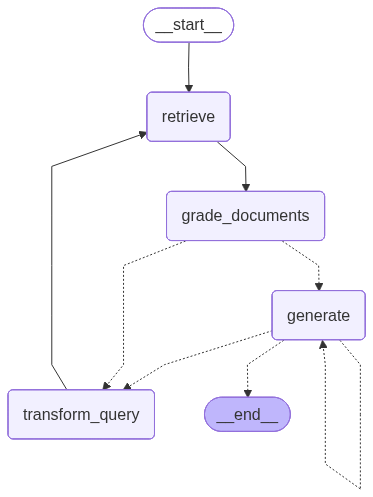

In [13]:
# =============================================================================
# Build Graph
# =============================================================================

def create_self_rag():

    builder = StateGraph(AgentState)

    # add nodes
    builder.add_node('retrieve', retrieve_node)
    builder.add_node('grade_documents', grade_documents_node)
    builder.add_node('generate', generate_node)
    builder.add_node('transform_query', transform_query_node)

    # define edges
    builder.add_edge(START, 'retrieve')
    builder.add_edge('retrieve', 'grade_documents')
    builder.add_edge('transform_query', 'retrieve')

    # conditional edges
    builder.add_conditional_edges('grade_documents', should_generate, ['transform_query', 'generate'])
    builder.add_conditional_edges('generate', check_answer_quality, ['generate', END, 'transform_query'])

    return builder.compile()

agent = create_self_rag()
agent

In [14]:
# =============================================================================
# Demo
# =============================================================================
query = "What was Amazon's revenue in 2023?"
result = agent.invoke({'messages': [HumanMessage(query)]})


[RETRIEVE] fetching documents...
[RETRIEVE] Query 1: What was Amazon's revenue in 2023?

[TOOL] retrieve_docs called
[QUERY] What was Amazon's revenue in 2023?
   [1] Doc 19: score=21.1139
   [2] Doc 10: score=20.5240
   [3] Doc 2: score=19.3040
[RETRIEVED] 3 documents
[GRADE] Evaluating document relevance
[GRADE] Relevance:  yes
[ROUTER] Assess graded documents
[ROUTER] Have relevant documents - generating answer
[GENERATE] Creating Answer
[ROUTER] Generation is gounded in documents
[ROUTER] Checking answer quality
[ROUTER] generation is good. - USEFUL


In [15]:
query = "Compare Apple and Amazon revenue in 2024 q1"

result = agent.invoke({'messages': [HumanMessage(query)]})


[RETRIEVE] fetching documents...
[RETRIEVE] Query 1: Compare Apple and Amazon revenue in 2024 q1

[TOOL] retrieve_docs called
[QUERY] Compare Apple and Amazon revenue in 2024 q1
   [1] Doc 1: score=21.6328
   [2] Doc 3: score=20.5197
   [3] Doc 0: score=17.8864
[RETRIEVED] 3 documents
[GRADE] Evaluating document relevance
[GRADE] Relevance:  no
[ROUTER] Assess graded documents
[ROUTER] No relevant documents - transforming query
New Search Queries: ['Apple total revenue Q1 2024', 'Amazon total revenue Q1 2024']
[RETRIEVE] fetching documents...
[RETRIEVE] Query 1: Apple total revenue Q1 2024

[TOOL] retrieve_docs called
[QUERY] Apple total revenue Q1 2024
   [1] Doc 1: score=21.6328
   [2] Doc 3: score=20.5197
   [3] Doc 0: score=17.8864
[RETRIEVED] 3 documents
[RETRIEVE] Query 2: Amazon total revenue Q1 2024

[TOOL] retrieve_docs called
[QUERY] Amazon total revenue Q1 2024
   [1] Doc 18: score=25.3514
   [2] Doc 0: score=23.2988
   [3] Doc 11: score=23.1968
[RETRIEVED] 3 documents
[GRAD

In [17]:
result

{'messages': [HumanMessage(content='Compare Apple and Amazon revenue in 2024 q1', additional_kwargs={}, response_metadata={}),
  AIMessage(content='## Apple vs. Amazon Q1 2024 Revenue Comparison\n\n### **Apple Inc. Revenue**  \nApple’s total net sales for the three months ended **March 30, 2024** were **$90.75 billion** (as reported in **Note 2 - Revenue** of its 10-Q filing [3]). This represents a **$4.08 billion decline** compared to the same period in 2023 ($94.84 billion). Key product segments included:  \n- **iPhone**: $45.96 billion (49.9% of total revenue)  \n- **Services**: $23.87 billion (26.3%)  \n- **Wearables, Home, and Accessories**: $7.91 billion (8.7%)  \n- **Mac and iPad**: $12.90 billion (14.2%)  \n\nDeferred revenue as of March 30, 2024, totaled **$12.6 billion**, with **64%** expected to be recognized within one year [3].  \n\n---\n\n### **Amazon.com Inc. Revenue**  \nAmazon’s consolidated net sales for **Q1 2024** (three months ended **March 31, 2024**) reached **$1

In [18]:
query = "What was Google's revenue in 2023?"

result = agent.invoke({'messages': [HumanMessage(query)]})


[RETRIEVE] fetching documents...
[RETRIEVE] Query 1: What was Google's revenue in 2023?

[TOOL] retrieve_docs called
[QUERY] What was Google's revenue in 2023?
   [1] Doc 21: score=25.8314
   [2] Doc 5: score=23.4856
   [3] Doc 16: score=21.7380
[RETRIEVED] 3 documents
[GRADE] Evaluating document relevance
[GRADE] Relevance:  no
[ROUTER] Assess graded documents
[ROUTER] No relevant documents - transforming query
New Search Queries: ['Google Inc. total revenue 2023', 'Google annual revenue 2023', 'Google financial report 2023 revenue']
[RETRIEVE] fetching documents...
[RETRIEVE] Query 1: Google Inc. total revenue 2023

[TOOL] retrieve_docs called
[QUERY] Google Inc. total revenue 2023
   [1] Doc 21: score=25.1399
   [2] Doc 5: score=22.8096
   [3] Doc 16: score=20.5585
[RETRIEVED] 3 documents
[RETRIEVE] Query 2: Google annual revenue 2023

[TOOL] retrieve_docs called
[QUERY] Google annual revenue 2023
   [1] Doc 20: score=25.4276
   [2] Doc 5: score=22.7817
   [3] Doc 15: score=21.3539


In [21]:
result['messages'][-1].pretty_print()

================================== Ai Message ==================================

## Google's 2023 Revenue

Google's total revenue for the fiscal year ended December 31, 2023, was **$307.4 billion** (or **$307,394 million**). This figure is detailed in the "Note 2. Revenues" section of Alphabet Inc.'s 10-K filing for 2023 [3].

### Breakdown of Revenue Streams
The revenue is disaggregated into several categories:
- **Google Search & other**: $175.0 billion  
- **YouTube ads**: $31.5 billion  
- **Google Network**: $31.3 billion  
- **Google advertising**: $237.9 billion  
- **Google subscriptions, platforms, and devices**: $34.7 billion  
- **Google Cloud**: $33.1 billion  
- **Other Bets**: $1.5 billion  
- **Hedging gains (losses)**: $0.2 billion  

These categories collectively sum to the total revenue of **$307.4 billion** [3].

### Key Context
- **Geographic Distribution**: The U.S. accounted for 47% of total revenue, followed by EMEA (30%) and APAC (17%) [3].
- **Revenue Backlog*